In [1]:
import pandas as pd
import os
import gensim

## Data Pre-Processing

In [2]:
abcnews = pd.read_csv("abcnews-date-text.csv")
abcnews.head(5)

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [3]:
"""apply preprocess function to dataset
observe the 3rd row to see the differences (ex. "a" and "g" are removed)
"""

def preprocess_data(input_text: str):
    final_text = list()
    for token in gensim.utils.simple_preprocess(input_text):
        if len(token) >= 3 and token not in gensim.parsing.preprocessing.STOPWORDS:
            final_text.append(token)
    return final_text

abc_docs = abcnews["headline_text"].map(preprocess_data)
abc_docs.head(5)

0    [aba, decides, community, broadcasting, licence]
1                 [act, witnesses, aware, defamation]
2         [calls, infrastructure, protection, summit]
3               [air, staff, aust, strike, pay, rise]
4       [air, strike, affect, australian, travellers]
Name: headline_text, dtype: object

In [4]:
abc_dict = gensim.corpora.Dictionary(abc_docs)
count = 0
for index, token in abc_dict.iteritems():
    count += 1
    if count > 5:
        break
    print(index, token)

0 aba
1 broadcasting
2 community
3 decides
4 licence


In [5]:
from sklearn.model_selection import train_test_split

abc_train, abc_test = train_test_split(abc_docs, test_size=0.05, train_size=0.05, random_state=42)
print(abc_train.shape)
print(abc_test.shape)

#removing too infrequent and too frequent words (irrelevant to topics but too common also reduces meaning)
abc_dict.filter_extremes(no_below=10, no_above=0.5)

#convert into each document into bag of words + TF-IDF
def convert_docs(input_dataset, input_dict):
    bow_corpus = [input_dict.doc2bow(doc) for doc in input_dataset]

    #TF-IDF conversion
    abc_tfidf = gensim.models.TfidfModel(bow_corpus)
    return abc_tfidf[bow_corpus]

#train and test corpus
train_corpus = convert_docs(abc_train, abc_dict)
test_corpus = convert_docs(abc_test, abc_dict)

print(type(train_corpus))

(62209,)
(62210,)
<class 'gensim.interfaces.TransformedCorpus'>


### Training LDA on 1M ABC Headlines

In [6]:
#enable logging of perplexity for convergence
import logging
logging.basicConfig(filename='gensim.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)

In [7]:
from gensim.models.callbacks import CoherenceMetric, DiffMetric, PerplexityMetric, ConvergenceMetric

callbacks = [
    PerplexityMetric(corpus=train_corpus, logger="shell", title="Perplexity (train)"),
    PerplexityMetric(corpus=test_corpus, logger="shell", title="Perplexity (test)"),
    # CoherenceMetric(corpus=train_corpus, texts=abc_train, coherence="c_v", logger="shell", title="Coherence"),
    ConvergenceMetric(distance='kullback_leibler',logger="shell", title="Convergence (kullback-leibler)")
]

In [8]:
#Train LDA on 1M dataset and output 10 topics

# abc_lda_model = gensim.models.LdaMulticore(
# multicore unable to support callbacks

num_epochs = 60

abc_lda_model = gensim.models.LdaModel(
    train_corpus, 
    num_topics=10, 
    random_state=42,
    id2word=abc_dict, 
    # eval_every=1000,
    passes=num_epochs, #num epochs
    # workers=None,
    callbacks=callbacks,
    iterations=50
)

abc_lda_model.print_topics(-1)

[(0,
  '0.007*"south" + 0.007*"climate" + 0.007*"change" + 0.006*"body" + 0.006*"blaze" + 0.006*"federal" + 0.006*"charge" + 0.005*"sydney" + 0.005*"farm" + 0.005*"north"'),
 (1,
  '0.012*"police" + 0.012*"man" + 0.010*"car" + 0.009*"crash" + 0.009*"woman" + 0.009*"charged" + 0.008*"injured" + 0.008*"abc" + 0.006*"murder" + 0.006*"chase"'),
 (2,
  '0.012*"missing" + 0.009*"year" + 0.008*"search" + 0.007*"interview" + 0.006*"family" + 0.006*"access" + 0.006*"old" + 0.005*"leaders" + 0.005*"season" + 0.005*"victim"'),
 (3,
  '0.011*"news" + 0.011*"rural" + 0.009*"country" + 0.008*"drought" + 0.008*"health" + 0.008*"safe" + 0.007*"farmers" + 0.007*"peter" + 0.006*"greens" + 0.006*"mental"'),
 (4,
  '0.011*"alleged" + 0.010*"arrested" + 0.010*"day" + 0.008*"second" + 0.007*"assault" + 0.006*"police" + 0.006*"cleared" + 0.006*"protest" + 0.005*"man" + 0.005*"young"'),
 (5,
  '0.007*"meeting" + 0.007*"tasmania" + 0.006*"scheme" + 0.006*"tasmanian" + 0.005*"waste" + 0.005*"meet" + 0.005*"acti

## Monitoring Convergence

- [Callbacks for Tracking and Visualization](https://radimrehurek.com/gensim/models/callbacks.html)
- [Example Notebook for Callbacks](https://notebook.community/piskvorky/gensim/docs/notebooks/Training_visualizations)


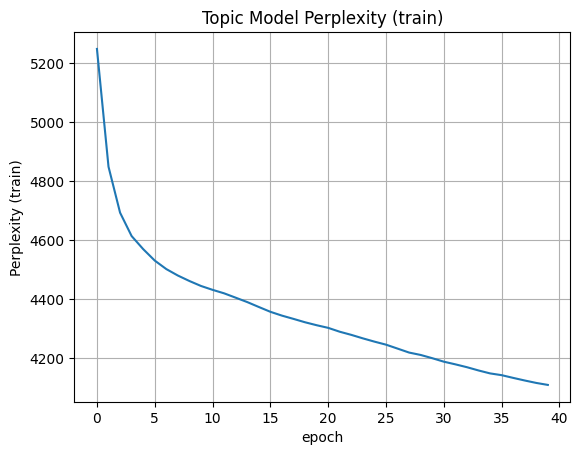

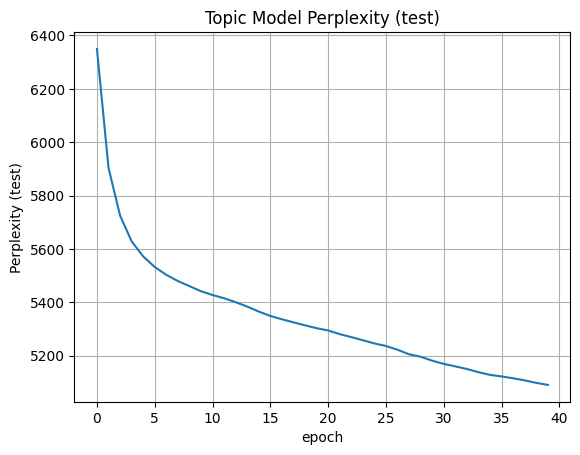

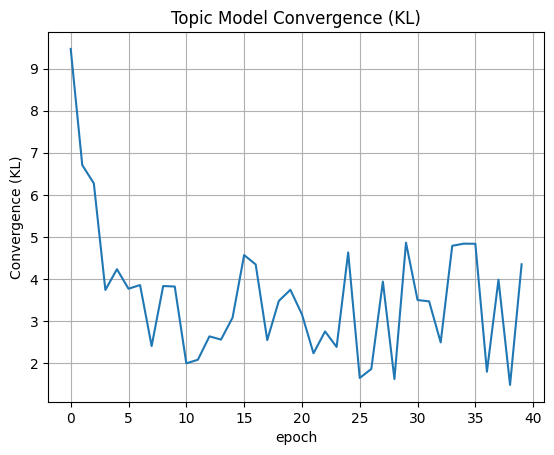

<Figure size 640x480 with 0 Axes>

In [9]:
import re
import matplotlib.pyplot as plt

patterns = {
    "Perplexity (train)": "Perplexity \(train\) estimate: (\d+\.\d+)",
    "Perplexity (test)": "Perplexity \(test\) estimate: (\d+\.\d+)",
    "Convergence (KL)": "Convergence \(kullback-leibler\) estimate: (\d+\.\d+)"
}

for title in patterns.keys():
    p = re.compile(patterns[title])
    matches = [p.findall(l) for l in open('gensim.log')]
    matches = [float(m[0]) for m in matches if len(m) > 0]

    plt.plot(matches)
    plt.ylabel("{}".format(title))
    plt.xlabel("epoch")
    plt.title("Topic Model {}".format(title))
    plt.grid()
    plt.figure()    

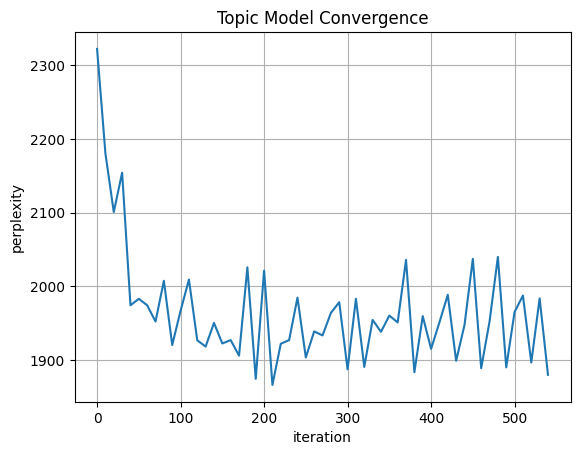

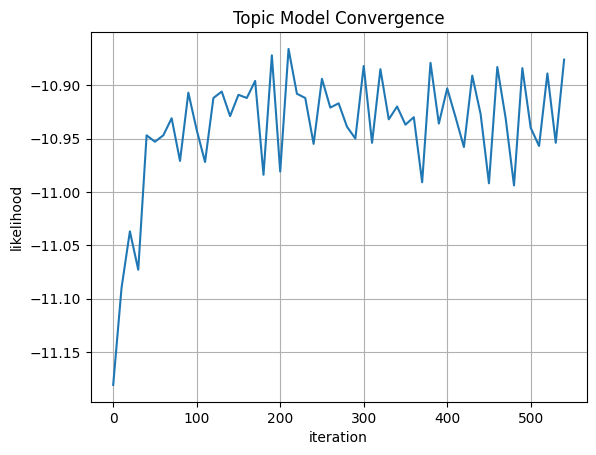

<Figure size 640x480 with 0 Axes>

In [9]:
#plot likelihood and perplexity
p = re.compile("(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
matches = [p.findall(l) for l in open('gensim.log')]
matches = [m for m in matches if len(m) > 0]
tuples = [t[0] for t in matches]

perplexity = [float(t[1]) for t in tuples]
likelihood = [float(t[0]) for t in tuples]
iter = list(range(0,len(tuples)*10,10))

metrics = {
    "perplexity": perplexity,
    "likelihood": likelihood
}

for title in metrics.keys():
    plt.plot(iter, metrics[title])
    plt.ylabel("{}".format(title))
    plt.xlabel("iteration")
    plt.title("Topic Model Convergence")
    plt.grid()
    # plt.savefig("convergence_liklihood.pdf")
    # plt.close()
    plt.figure()

In [11]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
gensimvis.prepare(abc_lda_model, corpus_tfidf, abc_dict)

/Users/seichang/miniconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/seichang/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/seichang/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/seichang/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/seichang/miniconda3/lib/python3.9/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.141395 -0.092559       1        1  13.773244
4     -0.289010 -0.154586       2        1  11.053307
1     -0.052141  0.330848       3        1  10.362456
0      0.140181 -0.082607       4        1   9.791671
5      0.051641  0.162926       5        1   9.727042
9     -0.018599  0.029248       6        1   9.545698
7     -0.245829 -0.045929       7        1   9.390396
3      0.042630  0.042560       8        1   9.252064
2      0.091833 -0.053259       9        1   8.669548
8      0.137898 -0.136641      10        1   8.434574, topic_info=              Term         Freq        Total Category  logprob  loglift
27458        covid  6430.000000  6430.000000  Default  30.0000  30.0000
315            man  7520.000000  7520.000000  Default  29.0000  29.0000
1548          news  4363.000000  4363.000000  Default  28.0000  28.0000
16799        trump  4490.000000  4490.000000  Default  27.0000  27.0000
27457  coronavirus  8489.000000  8489.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
3781         chris   622.783830   834.277651  Topic10  -5.8899   2.1805
453           says   854.328777  7107.325975  Topic10  -5.5738   0.3543
3231    government   691.327750  5276.655657  Topic10  -5.7855   0.4404
423            new   672.324172  8741.645720  Topic10  -5.8134  -0.0923
27457  coronavirus   670.384080  8489.532532  Topic10  -5.8162  -0.0659

[533 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
6333      4  0.192153    abc
6333      5  0.776211    abc
6333      6  0.031316    abc
2450      2  0.781687  abuse
2450      4  0.039988  abuse
...     ...       ...    ...
474       8  0.072605  world
474       9  0.045583  world
2780      8  0.997864  worst
7023      4  0.999122   wrap
2470      8  0.997489   york

[1071 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 2, 1, 6, 10, 8, 4, 3, 9])